# 1. 准备

In [2]:
# 设置可见的GPU 为 3 和4
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 3, 4"
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [3]:
# 导入必备的包

import torch.nn.functional as F
import csv

import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path, select_best_resolution

/home/kaiyu/miniconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


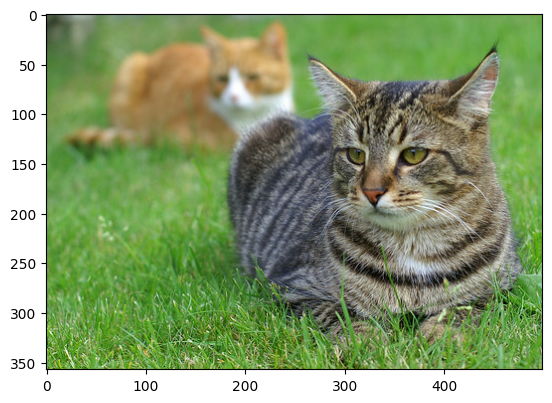

In [4]:
# 模型、测试样例设置

model_path = '/home/kaiyu/Model/liuhaotian/llava-v1.6-vicuna-7b/'
model_base = None
question = 'Is there a cat in the image?\\nAnswer the question using a single word or phrase.'
# question = 'describe the image'
# image_file = "./sample/dogsled.jpg"
image_file = "./sample/tigercat.jpg"
conv_mode = 'vicuna_v1'
temperature = 0
top_p = None
num_beams = 1

# from ImageNet
image = Image.open(image_file).convert('RGB')
# image = Image.open('./sample/dogsled.jpg')
imshow(image)

In [5]:
# 加载模型
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*copying from a non-meta parameter.*")

# Model
disable_torch_init()
model_path = os.path.expanduser(model_path)
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


/home/kaiyu/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/kaiyu/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


In [6]:
# input 处理

qs = question
cur_prompt = qs
if model.config.mm_use_im_start_end:
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
else:
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

image_tensor = process_images([image], image_processor, model.config)[0]


In [6]:
for i, ids in enumerate(input_ids[0]):
    if(i == 35):
        # print(i + 1 - len(temp_ids[0]), tokenizer.batch_decode([ids], skip_special_tokens=True), end='  ')
        continue
    print(i + 1 - len(input_ids[0]), tokenizer.batch_decode([ids], skip_special_tokens=True), end='  ')

-62 ['<s>']  -61 ['A']  -60 ['chat']  -59 ['between']  -58 ['a']  -57 ['curious']  -56 ['user']  -55 ['and']  -54 ['an']  -53 ['artificial']  -52 ['intelligence']  -51 ['assistant']  -50 ['.']  -49 ['The']  -48 ['assistant']  -47 ['gives']  -46 ['helpful']  -45 [',']  -44 ['detailed']  -43 [',']  -42 ['and']  -41 ['pol']  -40 ['ite']  -39 ['answers']  -38 ['to']  -37 ['the']  -36 ['user']  -35 ["'"]  -34 ['s']  -33 ['questions']  -32 ['.']  -31 ['US']  -30 ['ER']  -29 [':']  -28 ['']  -26 ['']  -25 ['<0x0A>']  -24 ['Is']  -23 ['there']  -22 ['a']  -21 ['cat']  -20 ['in']  -19 ['the']  -18 ['image']  -17 ['?']  -16 ['\\']  -15 ['n']  -14 ['Answer']  -13 ['the']  -12 ['question']  -11 ['using']  -10 ['a']  -9 ['single']  -8 ['word']  -7 ['or']  -6 ['phrase']  -5 ['.']  -4 ['A']  -3 ['SS']  -2 ['IST']  -1 ['ANT']  0 [':']  

# 2. 推理

In [7]:
# 推理

model.train()

image_tensor = image_tensor.unsqueeze(0).half().cuda()
image_tensor.requires_grad_()

output = model(
    input_ids=input_ids,
    use_cache=False,
    images=image_tensor,
    image_sizes=[image.size],
    output_attentions=True,
)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


# 3. 计算 CAM

## 3.1 获取注意力分数并激活梯度跟踪

In [8]:
attentions = output.attentions  # 假设out是模型的输出，并且包含注意力权重
for attn_layer in attentions:
    attn_layer.retain_grad()  # 保留非叶张量的梯度

## 3.2 预测输出并反向传播

In [9]:
prediction = output.logits
label_index = prediction.argmax(dim=-1)  # 获取输出索引，这里假设是argmax作为预测类别
prediction_score = prediction[:, -1, label_index[0][-1]]  # 获取对应的得分

prediction_score.backward()  # 对得分进行反向传播，生成梯度

## 3.3 获取梯度并计算 cam 值

In [10]:
gradient = [attn_layer.grad for attn_layer in attentions]  # 获取所有层的梯度

score_dict = {}
score_dict['attention'] = []
score_dict['cam'] = []
score_dict['grad'] = []

for attn_layer, grad_layer in zip(attentions, gradient):

    # attention score
    attn_single = attn_layer
    attn_single = attn_single.mean(dim=1)  # 假设我们合并头部的注意力
    # attn_single = F.relu(attn_single)
    score_dict['attention'].append(attn_single)

    if(grad_layer is None):
        continue
    
    # grad score
    grad_single = grad_layer
    grad_single = grad_single.mean(dim=1)  # 假设我们合并头部的注意力
    # grad_single = F.relu(grad_single)
    score_dict['grad'].append(grad_single)

    # cam score
    # 广播后点乘的shape可能是 [batch_size, num_heads, seq_length, seq_length]
    grad_weighted_attn = grad_layer * attn_layer
    grad_weighted_attn = grad_weighted_attn.mean(dim=1)  # 假设我们合并头部的注意力
    # grad_weighted_attn = F.relu(grad_weighted_attn)
    score_dict['cam'].append(grad_weighted_attn)

## 3.4 保存 Score

In [11]:
target_tokens = [-1]  # 固定

# 准备表头
headers = []
data = []

# 遍历 score_dict
for score_type, score_list in score_dict.items():
    for layer_num, scores in enumerate(score_list):
        header = f"{score_type}_{layer_num}"
        headers.append(header)
        column_data = []
        for target_token in target_tokens:
            res = scores[0][target_token, -len(input_ids[0]):]
            column_data.extend([r.item() for r in res])
        data.append(column_data)

# 转置数据，使每行对应一个数据点
transposed_data = list(zip(*data))

# 获取当前时间
current_time = time.strftime("%m%d%H%M%S", time.localtime())

# 写入 CSV 文件
with open(f"result/score/{current_time}_{image_file.replace('.', '_').replace('/', '_')}_score.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    # 写入表头
    writer.writerow(headers)
    # 写入数据
    writer.writerows(transposed_data)

## 3.5 可视化

In [26]:
# 显示 heatmap 的函数

def get_heatmap_img(visual_cam, image):
    visual_cam = visual_cam.reshape(24, 24).cpu().detach().float()
    # 对 CAM 分数进行拉伸差值
    H, W = image.size
    cam = F.interpolate(visual_cam.unsqueeze(0).unsqueeze(0), size=(W, H), mode='bilinear', align_corners=False).squeeze()

    # 创建一个新的图像
    fig, ax = plt.subplots()
    
    # 显示原始图像
    ax.imshow(image)

    # 叠加热力图
    ax.imshow(cam, alpha=0.5, cmap='jet')
    
    # 返回图像对象
    return fig, ax

In [36]:
# 按照特定层显示 heatmap 的函数

def show_heatmap_img(score_dict, image, score_type, layer_num, show_image=True, save_image=False):
    target_token = -1
    visual_cam = score_dict[score_type][layer_num][0][target_token, 35:611]
    fig, ax = get_heatmap_img(visual_cam, image)
    ax.set_title(f'Layer {layer_num}, Type {score_type}')
    if show_image:
        fig.show()
    if save_image:
        # 获取当前时间
        current_time = time.strftime("%m%d%H%M%S", time.localtime())
            # 保存图像
        fig.savefig(f"result/image/{current_time}_{image_file.replace('.', '_').replace('/', '_')}_{score_type}_{layer_num}_heatmap.png")
        plt.close(fig)  # 关闭图像以释放内存

In [37]:
show_heatmap_img(score_dict, image, 'attention', 0, False, True)

In [32]:
score_type = 'attention'
# score_type = 'grad'
# score_type = 'cam'


for layer_num in range(32):
    show_heatmap_img(score_dict, image, score_type, layer_num)